In [34]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [35]:
from functools import partial
from pathlib import Path
import argparse
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as sig
import psola

In [36]:
SEMITONES_IN_OCTAVE = 12


def degrees_from(scale: str):
    """Return the pitch classes (degrees) that correspond to the given scale"""
    degrees = librosa.key_to_degrees(scale)
    # To properly perform pitch rounding to the nearest degree from the scale, we need to repeat
    # the first degree raised by an octave. Otherwise, pitches slightly lower than the base degree
    # would be incorrectly assigned.
    degrees = np.concatenate((degrees, [degrees[0] + SEMITONES_IN_OCTAVE]))
    return degrees


def closest_pitch(f0):
    """Round the given pitch values to the nearest MIDI note numbers"""
    midi_note = np.around(librosa.hz_to_midi(f0))
    # To preserve the nan values.
    nan_indices = np.isnan(f0)
    midi_note[nan_indices] = np.nan
    # Convert back to Hz.
    return librosa.midi_to_hz(midi_note)


def closest_pitch_from_scale(f0, scale):
    """Return the pitch closest to f0 that belongs to the given scale"""
    # Preserve nan.
    if np.isnan(f0):
        return np.nan
    degrees = degrees_from(scale)
    midi_note = librosa.hz_to_midi(f0)
    # Subtract the multiplicities of 12 so that we have the real-valued pitch class of the
    # input pitch.
    degree = midi_note % SEMITONES_IN_OCTAVE
    # Find the closest pitch class from the scale.
    degree_id = np.argmin(np.abs(degrees - degree))
    # Calculate the difference between the input pitch class and the desired pitch class.
    degree_difference = degree - degrees[degree_id]
    # Shift the input MIDI note number by the calculated difference.
    midi_note -= degree_difference
    # Convert to Hz.
    return librosa.midi_to_hz(midi_note)


def aclosest_pitch_from_scale(f0, scale):
    """Map each pitch in the f0 array to the closest pitch belonging to the given scale."""
    sanitized_pitch = np.zeros_like(f0)
    for i in np.arange(f0.shape[0]):
        sanitized_pitch[i] = closest_pitch_from_scale(f0[i], scale)
    # Perform median filtering to additionally smooth the corrected pitch.
    smoothed_sanitized_pitch = sig.medfilt(sanitized_pitch, kernel_size=11)
    # Remove the additional NaN values after median filtering.
    smoothed_sanitized_pitch[np.isnan(smoothed_sanitized_pitch)] = sanitized_pitch[
        np.isnan(smoothed_sanitized_pitch)
    ]
    return smoothed_sanitized_pitch




In [37]:
vocals = {
    "blue_pill": {"file": "blue_pill", "scale": "E♭:min"},
    "ransom": {"file": "ransom", "scale": "G:min"},
    "bout_a_million": {"file": "bout_a_million", "scale": "C:min"},
    "no_bystanders": {"file": "no_bystanders", "scale": "C#:maj"},
    "xo_tour_life": {"file": "xo_tour_life", "scale": "B:min"},
}

vocal_used = vocals["ransom"]

In [38]:
filepath = Path(f'./samples/{vocal_used["file"]}.wav')
filepath_antares = Path(f'./antares/{vocal_used["file"]}.wav')

# Load the audio file.
y, sr = librosa.load(str(filepath), sr=None, mono=False)
antares_y, _ = librosa.load(str(filepath_antares), sr=None, mono=False)


# Only mono-files are handled. If stereo files are supplied, only the first channel is used.
if y.ndim > 1:
    y = y[0, :]
if antares_y.ndim > 1:
    antares_y = antares_y[0, :]

min_size = min(len(y), len(antares_y))

# Truncate both arrays to the smallest size
y = y[:min_size]
antares_y = antares_y[:min_size]

# Set some basis parameters.
frame_length = 2048
hop_length = frame_length // 4
fmin = librosa.note_to_hz("C2")
fmax = librosa.note_to_hz("C7")

In [39]:
f0, voiced_flag, voiced_probabilities = librosa.pyin(
    y,
    frame_length=frame_length,
    hop_length=hop_length,
    sr=sr,
    fmin=fmin,
    fmax=fmax,
)

f0_antares, _, _ = librosa.pyin(
    antares_y,
    frame_length=frame_length,
    hop_length=hop_length,
    sr=sr,
    fmin=fmin,
    fmax=fmax,
)

In [40]:
# Apply the chosen adjustment strategy to the pitch.
corrected_f0 = aclosest_pitch_from_scale(f0, vocal_used["scale"])

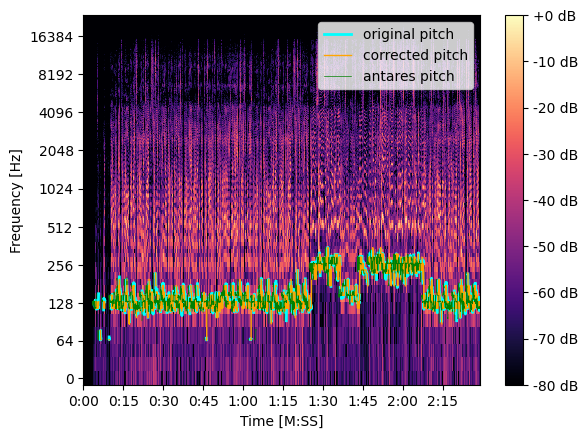

In [41]:
# Plot the spectrogram, overlaid with the original pitch trajectory and the adjusted
# pitch trajectory.
stft = librosa.stft(y, n_fft=frame_length, hop_length=hop_length)
time_points = librosa.times_like(stft, sr=sr, hop_length=hop_length)
log_stft = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(
    log_stft,
    x_axis="time",
    y_axis="log",
    ax=ax,
    sr=sr,
    hop_length=hop_length,
    fmin=fmin,
    fmax=fmax,
)

fig.colorbar(img, ax=ax, format="%+2.f dB")

ax.plot(time_points, f0, label="original pitch", color="cyan", linewidth=2)

ax.plot(
    time_points,
    corrected_f0,
    label="corrected pitch",
    color="orange",
    linewidth=1,
)

ax.plot(
    time_points,
    f0_antares,
    label="antares pitch",
    color="green",
    linewidth=0.5,
)

ax.legend(loc="upper right")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [M:SS]")
plt.savefig("charts/" + filepath.stem + ".png", dpi=300, bbox_inches="tight")



In [42]:
# Pitch-shifting using the PSOLA algorithm.
pitch_corrected_y = psola.vocode(
    y, sample_rate=int(sr), target_pitch=corrected_f0, fmin=fmin, fmax=fmax
)

In [43]:
# Write the corrected audio to an output file.
sf.write(str("out/" + (filepath.stem + filepath.suffix)), pitch_corrected_y, sr)

# Save verilog-readable format
np.savetxt(f'./encoded/{vocal_used["file"]}.in', y, fmt="%0.15f")
np.savetxt(f'./encoded/{vocal_used["file"]}.out', pitch_corrected_y, fmt="%0.15f")
np.savetxt(f'./encoded/{vocal_used["file"]}.reference', antares_y, fmt="%0.15f")

print(y.shape)
print(pitch_corrected_y.shape)
print(antares_y.shape)

(7158670,)
(7158670,)
(7158670,)


In [44]:
# test reconstructing wav file

y_r = np.loadtxt(f'./encoded/{vocal_used["file"]}.in')
y_r_corrected = np.loadtxt(f'./encoded/{vocal_used["file"]}.out')

print(y_r.shape)
print(y_r_corrected.shape)

(7158670,)
(7158670,)
